<a href="https://colab.research.google.com/github/rebeccahe1998/E4511-2021-HE/blob/main/nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

---



In [ ]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

!pip install hyperopt

# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
# import numpy as np
# import pandas as pd
import os
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle


In [ ]:
! pip install bravado

In [16]:
#! time conda install -c conda-forge -y mordred bravado molvs
# There is a problem with the previously imported cffi, so delete it and load it with AMPL instead
#if 'cffi' in sys.modules:
#  del sys.modules['cffi']
#import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import model_pipeline as mp
import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data
from atomsci.ddm.pipeline import model_wrapper
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Read CSV

---



In [4]:
! wget https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/data/curated_combined_df_1.csv

--2021-04-08 15:44:45--  https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/data/curated_combined_df_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541554 (529K) [text/plain]
Saving to: ‘curated_combined_df_1.csv’

curated_combined_df 100%[===================>] 528.86K  --.-KB/s    in 0.04s   

2021-04-08 15:44:45 (12.7 MB/s) - ‘curated_combined_df_1.csv’ saved [541554/541554]



In [5]:
import pandas as pd
df = pd.read_csv('curated_combined_df_1.csv', index_col=0)
df

,compound_id,base_rdkit_smiles,active,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,PXC50
0,CHEMBL599233,CC(C(=O)c1cccc([N+](=O)[O-])c1)N1CCCCC1,0,5.000000,0.000000,0.000000,0,5.000000
1,CHEMBL2047573,OC(CCN1CCC(O)(Cc2ccccc2)CC1)c1ccc(Cl)c(Cl)c1,1,6.249574,0.000738,0.013645,0,6.248721
2,CHEMBL1083410,CNC[C@H](O)CCN1c2ccccc2N(c2ccccc2F)S1(=O)=O,0,5.619388,0.001060,0.021791,0,5.618163
3,CHEMBL3673162,COc1ccc(-c2ccc3c(c2)CN2CCC3(c3ccc(Cl)c(Cl)c3)C...,1,8.229574,0.000602,0.005177,0,8.229148
4,CHEMBL2096860,COC(=O)[C@H]1C2CCC(C[C@@H]1c1ccc(I)cc1)N2C,1,7.642648,0.002293,0.017351,0,7.643974
...,...,...,...,...,...,...,...,...
5471,CHEMBL218952,C[C@@H](O)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O...,0,3.700000,NaN,0.000000,0,3.700000
5472,CHEMBL3143431,CC[C@H](C)[C@H](NC(=O)[C@@H](NC[C@H](CC(C)C)NC...,1,8.100000,NaN,0.000000,0,8.100000
5473,CHEMBL411570,C[C@@H](O)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O...,0,3.740000,NaN,0.000000,0,3.740000
5474,CHEMBL383931,C[C@H](NC(=O)[C@@H](N)Cc1ccc(-c2ccc(C[C@H](N)C...,0,3.760000,NaN,0.000000,0,3.760000


In [6]:
df[df.compound_id.duplicated(keep=False)==True].sort_values(by='compound_id')

,compound_id,base_rdkit_smiles,active,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,PXC50


In [8]:
df.to_csv("curated_combined_df_1.csv")

# Split

---



In [9]:
working_dir = '/content'

In [10]:
# data splits based on the scaffold of small molecules.

response_col = ['VALUE_NUM_mean']
smiles_col = 'base_rdkit_smiles'
compound_id = 'compound_id'
train_file = "curated_combined_df_1.csv"
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",   #Boolean flag for using an input file from the LLNL specific datastore system based on a key of dataset_key
        "save_results": "False", # Save model results to MongoDB,
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",  # Boolean flag for loading in previously split train, validation, and test csv files
        "split_only": "True",   # indicate splitting of the datasets when running the hyperparameter search
        'split_strategy':'train_valid_test',
        "featurizer": "graphconv",
        'descriptor_type': 'graphconv',
        "model_type": "NN",
        "verbose": "True",
        "transformers": "True", #using transformation on regression output
        "rerun": "False",
        "result_dir": working_dir
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-04-08 15:45:45,771 ['split_stategy'] are not part of the accepted list of parameters and will be ignored


number of features: 75


2021-04-08 15:46:08,137 Splitting data by scaffold
2021-04-08 15:46:25,625 Dataset split table saved to /curated_combined_df_1_train_valid_test_scaffold_bf84e0d2-92bd-4cb4-af4d-659dcd1b2d31.csv


In [11]:
split_uuid = pl.split_dataset()
split_uuid

number of features: 75


2021-04-08 15:48:58,110 Splitting data by scaffold
2021-04-08 15:49:15,513 Dataset split table saved to /curated_combined_df_1_train_valid_test_scaffold_0742566a-68ab-400e-b5be-e53a6401bfb5.csv


'0742566a-68ab-400e-b5be-e53a6401bfb5'

In [12]:
listing = glob.glob(os.path.join("/", "curated_combined_df_1_train_valid_test_scaffold_*"))

# Train Initial NN

---



In [20]:
# train inital CNN model

#name = listing[0]
#name.split("_")[-1].split(".")[0]


params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,   # UUID for csv file containing train, validation, and test split information
        "previously_split": "True",
        "featurizer": "graphconv",
        "model_type": "NN",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }

In [ ]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

In [22]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.491


In [23]:
pred_data = pl.model_wrapper.get_perf_data(subset="test", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of test set: {pred_results['r2_score']:.3f}")

R2 score of test set: 0.328


# Grid Search 1

Since I don't have much prior experience on tuning a CNN model on this dataset, I will do grid search 

In [24]:
params

{'data_owner': 'username',
 'dataset_key': 'curated_combined_df_1.csv',
 'datastore': 'False',
 'featurizer': 'graphconv',
 'id_col': 'compound_id',
 'lc_account': 'None',
 'max_epochs': '70',
 'model_type': 'NN',
 'prediction_type': 'regression',
 'previously_split': 'True',
 'rerun': 'False',
 'response_cols': ['VALUE_NUM_mean'],
 'result_dir': 'ampl_output',
 'save_results': 'False',
 'smiles_col': 'base_rdkit_smiles',
 'split_uuid': '0742566a-68ab-400e-b5be-e53a6401bfb5',
 'system': 'LC',
 'transformers': 'True',
 'verbose': 'True'}

In [ ]:
learning_rate = [0.0003]
max_epochs = [30,90]
batch_size = [16,50,90]

learning_rate_list = []
max_epochs_list = []
batch_size_list = []
valid_r2_list = []
for lr in learning_rate:
    for me in max_epochs:
        for bs in batch_size:
            params["learning_rate"] = lr
            params["max_epochs"] = me
            params["batch_size"] = bs
            learning_rate_list.append(lr)
            max_epochs_list.append(me)
            batch_size_list.append(bs)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            # predict on validation set
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)
            #print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

In [ ]:
perf_df = pd.DataFrame({"learning rate": learning_rate_list, "max epoches": max_epochs_list, "batch size": batch_size_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,learning rate,max epoches,batch size,valid_r2_score
3,0.0003,90,16,0.512176
4,0.0003,90,50,0.488229
5,0.0003,90,90,0.458005
0,0.0003,30,16,0.435182
2,0.0003,30,90,0.410229
1,0.0003,30,50,0.368990


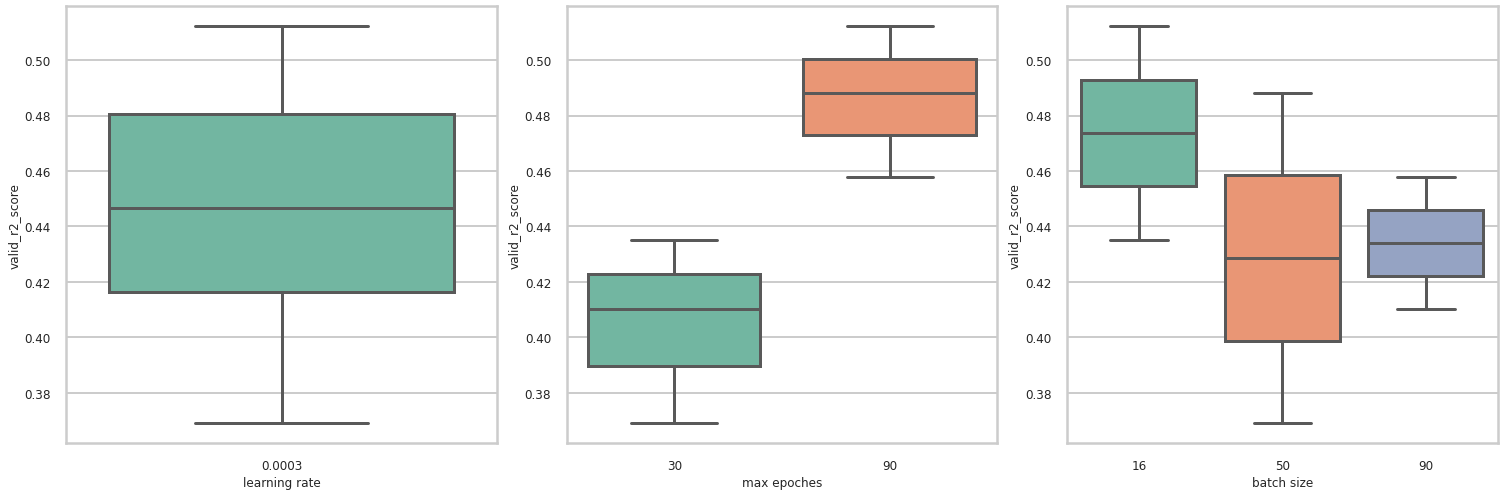

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="learning rate", y="valid_r2_score", ax=ax[0])
sns.boxplot(data=perf_df, x="max epoches", y="valid_r2_score", ax=ax[1])
sns.boxplot(data=perf_df, x="batch size", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

# Refined Grid Search

In [ ]:

learning_rate = [0.0005]
max_epochs = [100]
batch_size = [10,13]

learning_rate_list = []
max_epochs_list = []
batch_size_list = []
valid_r2_list = []
for lr in learning_rate:
    for me in max_epochs:
        for bs in batch_size:
            params["learning_rate"] = lr
            params["max_epochs"] = me
            params["batch_size"] = bs
            learning_rate_list.append(lr)
            max_epochs_list.append(me)
            batch_size_list.append(bs)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            # predict on validation set
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)


In [27]:
perf_df2 = pd.DataFrame({"learning rate": learning_rate_list, "max epoches": max_epochs_list, "batch size": batch_size_list, "valid_r2_score": valid_r2_list})
perf_df2.sort_values(by="valid_r2_score", ascending=False)

,learning rate,max epoches,batch size,valid_r2_score
0,0.0005,100,10,0.507958
1,0.0005,100,13,0.500097


In [29]:
#  Retrieve model metadata and performance metrics stored in the filesystem from a hyperparameter search run.
cmp.get_filesystem_perf_results('ampl_output', pred_type='regression').sort_values(by='valid_r2_score', ascending=False)

Found data for 3 models under ampl_output


,model_uuid,model_type,dataset_key,featurizer,splitter,model_score_type,feature_transform_type,learning_rate,dropouts,layer_sizes,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,model_choice_score,train_r2_score,train_rms_score,train_mae_score,train_num_compounds,valid_r2_score,valid_rms_score,valid_mae_score,valid_num_compounds,test_r2_score,test_rms_score,test_mae_score,test_num_compounds
1,be665995-f1a4-4bec-8f9c-704b2e7b3228,NN,curated_combined_df_1.csv,graphconv,scaffold,r2,normalization,0.0005,"0.25,0.25,0.25","64,64,128",99,100,NaN,NaN,NaN,0.507958,0.803551,0.533593,0.392290,4380,0.507958,0.839806,0.652683,548,0.259016,0.926407,0.731251,548
0,91110ae2-0699-4f4b-a39c-432c33593978,NN,curated_combined_df_1.csv,graphconv,scaffold,r2,normalization,0.0005,"0.25,0.25,0.25","64,64,128",87,100,NaN,NaN,NaN,0.500097,0.779039,0.565904,0.414930,4380,0.500097,0.846488,0.656654,548,0.301021,0.899766,0.688978,548
2,39a5d3f7-bcdb-4472-bdb0-d78047c11ae5,NN,curated_combined_df_1.csv,graphconv,scaffold,r2,normalization,0.0005,"0.25,0.25,0.25","64,64,128",68,70,NaN,NaN,NaN,0.491148,0.717928,0.639389,0.489607,4380,0.491148,0.854030,0.674916,548,0.328498,0.881904,0.688422,548


In [30]:
# save the best model
cmp.copy_best_filesystem_models(pred_type="regression", dest_dir=working_dir, 
                                result_dir='ampl_output', force_update=False)


Found data for 3 models under ampl_output
Copied curated_combined_df_1_model_be665995-f1a4-4bec-8f9c-704b2e7b3228.tar.gz


,model_uuid,model_type,dataset_key,featurizer,splitter,model_score_type,feature_transform_type,learning_rate,dropouts,layer_sizes,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,model_choice_score,train_r2_score,train_rms_score,train_mae_score,train_num_compounds,valid_r2_score,valid_rms_score,valid_mae_score,valid_num_compounds,test_r2_score,test_rms_score,test_mae_score,test_num_compounds
1,be665995-f1a4-4bec-8f9c-704b2e7b3228,NN,curated_combined_df_1.csv,graphconv,scaffold,r2,normalization,0.0005,"0.25,0.25,0.25","64,64,128",99,100,NaN,NaN,NaN,0.507958,0.803551,0.533593,0.39229,4380,0.507958,0.839806,0.652683,548,0.259016,0.926407,0.731251,548


# Test??

---



---




In [32]:
! pip install molvs

     |████████████████████████████████| 71kB 6.3MB/s 
  Created wheel for molvs: filename=MolVS-0.1.1-cp37-none-any.whl size=32376 sha256=3c0825751af49e3297a42f5dd7f3d900c83c943fcf8319b1328ac360b6402f18
  Stored in directory: /root/.cache/pip/wheels/30/37/a8/8ac8147605c9de6b45ffd66d1cc19761d41467db12b34a0de8
Successfully built molvs


In [33]:
from atomsci.ddm.pipeline import predict_from_model

In [ ]:
# Test loading model from tarball and running predictions
test = predict_from_model.predict_from_model_file(model_path='curated_combined_df_1_model_be665995-f1a4-4bec-8f9c-704b2e7b3228.tar.gz',
                            input_df = df,
                            id_col='compound_id',
                            smiles_col='base_rdkit_smiles',
                            response_col='VALUE_NUM_mean',
                            is_featurized=False,
                            dont_standardize=True)

In [35]:
from sklearn.metrics import r2_score, mean_squared_error
print(r2_score(test.VALUE_NUM_mean_actual, test.VALUE_NUM_mean_pred))
print(mean_squared_error(test.VALUE_NUM_mean_actual, test.VALUE_NUM_mean_pred))

0.7203544085833231
0.4037001181496597
